In [ ]:
# 1. Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# 2. Create and move into a specific project folder
import os
project_folder = '/content/drive/MyDrive/Colab_Projects/RunningLMM'

if not os.path.exists(project_folder):
    os.makedirs(project_folder)
    print(f"Created folder: {project_folder}")

# 3. Change the working directory to this folder
os.chdir(project_folder)
print(f"Current Directory: {os.getcwd()}")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Current Directory: /content/drive/MyDrive/Colab_Projects/RunningLMM


In [ ]:
!curl -fsSL https://deb.nodesource.com/setup_20.x | sudo -E bash - && \
sudo apt-get install -y nodejs && \
sudo npm install -g @anthropic-ai/claude-code && \
export PATH=/usr/bin:$PATH

In [ ]:
!claude

In [ ]:
!pip install -q transformers torch datasets accelerate tqdm huggingface_hub bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.1/59.1 MB 15.6 MB/s eta 0:00:00


In [ ]:
!hf auth login


    _|    _|  _|    _|    _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|_|_|_|    _|_|      _|_|_|  _|_|_|_|
    _|    _|  _|    _|  _|        _|          _|    _|_|    _|  _|            _|        _|    _|  _|        _|
    _|_|_|_|  _|    _|  _|  _|_|  _|  _|_|    _|    _|  _|  _|  _|  _|_|      _|_|_|    _|_|_|_|  _|        _|_|_|
    _|    _|  _|    _|  _|    _|  _|    _|    _|    _|    _|_|  _|    _|      _|        _|    _|  _|        _|
    _|    _|    _|_|      _|_|_|    _|_|_|  _|_|_|  _|      _|    _|_|_|      _|        _|    _|    _|_|_|  _|_|_|_|

    To log in, `huggingface_hub` requires a token generated from https://huggingface.co/settings/tokens .
Enter your token (input will not be visible): 
Add token as git credential? (Y/n) y
Token is valid (permission: read).
The token `token1` has been saved to /root/.cache/huggingface/stored_tokens
Cannot authenticate through git-credential as no helper is defined on your machine.
You might have to re-authenticate when pus

In [ ]:
## llama_mmlu_eval
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "meta-llama/Llama-3.2-1B-Instruct"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = 8 # Change to 4 or 8 to enable quantization

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    # "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    # "clinical_knowledge", "college_biology", "college_chemistry",
    # "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("✓ Running in Google Colab")
        in_colab = True
    except:
        print("✓ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"✓ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"✓ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✓ GPU Available: {gpu_name}")
        print(f"✓ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("✓ Apple Metal (MPS) Available")
        print("✓ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("⚠️  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"✓ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"❌ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"❌ Apple METAL is incompatible with quantization")
            print("✓ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("✓ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("✓ Hugging Face authenticated")
        else:
            print("⚠️  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("⚠️  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("✓ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("✓ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\n❌ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    for example in tqdm(dataset, desc=f"Testing {subject}", leave=True):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)
        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        if predicted_answer == correct_answer:
            correct += 1
        total += 1

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"✓ Result: {correct}/{total} correct = {accuracy:.2f}%")

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"Duration: {duration/60:.1f} minutes")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "duration_seconds": duration,
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\n✓ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\n📊 Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\n📉 Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("💾 To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\n✅ Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()


In [ ]:
"""
Llama 3.2-1B MMLU Evaluation Script (Laptop Optimized with Quantization)

This script evaluates Llama 3.2-1B on the MMLU benchmark.
Optimized for laptops with 4-bit or 8-bit quantization to reduce memory usage.

Quantization options:
- 4-bit: ~1.5 GB VRAM/RAM (default for laptop)
- 8-bit: ~2.5 GB VRAM/RAM
- No quantization: ~5 GB VRAM/RAM

Usage:
1. Install: pip install transformers torch datasets accelerate tqdm bitsandbytes
2. Login: huggingface-cli login
3. Run: python llama_mmlu_eval_quantized.py

Set QUANTIZATION_BITS below to choose quantization level.
"""

import torch
from transformers import AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig
from datasets import load_dataset
import json
from tqdm.auto import tqdm
import os
from datetime import datetime
import sys
import platform
import time

# ============================================================================
# CONFIGURATION - Modify these settings
# ============================================================================

MODEL_NAME = "Qwen/Qwen2.5-7B"

# GPU settings
# If True, will attempt to use the best available GPU (CUDA for NVIDIA, MPS for Apple Silicon)
# If False, will always use CPU regardless of available hardware
USE_GPU = True  # Set to False to force CPU-only execution

MAX_NEW_TOKENS = 1

# Quantization settings
# Options: 4, 8, or None (default is None for full precision)
#
# To enable quantization, change QUANTIZATION_BITS to one of the following:
#   QUANTIZATION_BITS = 4   # 4-bit quantization: ~1.5 GB memory (most memory efficient)
#   QUANTIZATION_BITS = 8   # 8-bit quantization: ~2.5 GB memory (balanced quality/memory)
#   QUANTIZATION_BITS = None  # No quantization: ~5 GB memory (full precision, best quality)
#
# Notes:
# - Quantization requires the 'bitsandbytes' package: pip install bitsandbytes
# - Quantization only works with CUDA (NVIDIA GPUs), not with Apple Metal (MPS)
# - If using Apple Silicon, quantization will be automatically disabled

QUANTIZATION_BITS = None  # Change to 4 or 8 to enable quantization

# Verbose output settings
# If True, prints each question, the model's answer, and whether it was correct
VERBOSE_OUTPUT = True  # Set to True to see detailed question-by-question output

# For quick testing, you can reduce this list
MMLU_SUBJECTS = [
    "abstract_algebra", "anatomy",
    "astronomy", "business_ethics",
    "clinical_knowledge", "college_biology", "college_chemistry",
    "college_computer_science", "college_mathematics", "college_medicine",
    # "college_physics", "computer_security", "conceptual_physics",
    # "econometrics", "electrical_engineering", "elementary_mathematics",
    # "formal_logic", "global_facts", "high_school_biology",
    # "high_school_chemistry", "high_school_computer_science",
    # "high_school_european_history", "high_school_geography",
    # "high_school_government_and_politics", "high_school_macroeconomics",
    # "high_school_mathematics", "high_school_microeconomics",
    # "high_school_physics", "high_school_psychology", "high_school_statistics",
    # "high_school_us_history", "high_school_world_history", "human_aging",
    # "human_sexuality", "international_law", "jurisprudence",
    # "logical_fallacies", "machine_learning", "management", "marketing",
    # "medical_genetics", "miscellaneous", "moral_disputes", "moral_scenarios",
    # "nutrition", "philosophy", "prehistory", "professional_accounting",
    # "professional_law", "professional_medicine", "professional_psychology",
    # "public_relations", "security_studies", "sociology", "us_foreign_policy",
    # "virology", "world_religions"
]


class TimingStats:
    """Track real time, CPU time, and GPU time for evaluation"""

    def __init__(self, device):
        self.device = device
        self.real_time_start = None
        self.cpu_time_start = None
        self.gpu_time_total = 0.0
        self.real_time_total = 0.0
        self.cpu_time_total = 0.0

        # CUDA events for GPU timing
        self.cuda_available = device == "cuda" and torch.cuda.is_available()
        if self.cuda_available:
            self.start_event = torch.cuda.Event(enable_timing=True)
            self.end_event = torch.cuda.Event(enable_timing=True)

    def start(self):
        """Start timing"""
        self.real_time_start = time.perf_counter()
        self.cpu_time_start = time.process_time()
        if self.cuda_available:
            torch.cuda.synchronize()
            self.start_event.record()

    def stop(self):
        """Stop timing and accumulate"""
        if self.cuda_available:
            self.end_event.record()
            torch.cuda.synchronize()
            self.gpu_time_total += self.start_event.elapsed_time(self.end_event) / 1000.0  # Convert ms to seconds

        self.real_time_total += time.perf_counter() - self.real_time_start
        self.cpu_time_total += time.process_time() - self.cpu_time_start

    def reset(self):
        """Reset all timings"""
        self.gpu_time_total = 0.0
        self.real_time_total = 0.0
        self.cpu_time_total = 0.0

    def get_summary(self):
        """Return timing summary as dict"""
        return {
            "real_time_seconds": self.real_time_total,
            "cpu_time_seconds": self.cpu_time_total,
            "gpu_time_seconds": self.gpu_time_total if self.cuda_available else None,
        }

    def format_time(self, seconds):
        """Format time in human-readable format"""
        if seconds < 60:
            return f"{seconds:.2f} seconds"
        elif seconds < 3600:
            return f"{seconds/60:.2f} minutes ({seconds:.2f} seconds)"
        else:
            return f"{seconds/3600:.2f} hours ({seconds:.2f} seconds)"

    def print_summary(self):
        """Print formatted timing summary"""
        print(f"  Real Time (Wall Clock): {self.format_time(self.real_time_total)}")
        print(f"  CPU Time: {self.format_time(self.cpu_time_total)}")
        if self.cuda_available:
            print(f"  GPU Time (CUDA Kernel): {self.format_time(self.gpu_time_total)}")
        elif self.device == "mps":
            print(f"  GPU Time: N/A (MPS does not support precise GPU timing)")
        else:
            print(f"  GPU Time: N/A (running on CPU)")


def detect_device():
    """Detect the best available device (CUDA, MPS, or CPU)"""

    # If GPU is disabled, always use CPU
    if not USE_GPU:
        return "cpu"

    # Check for CUDA
    if torch.cuda.is_available():
        return "cuda"

    # Check for Apple Silicon with Metal
    if torch.backends.mps.is_available():
        # Check if we're actually on Apple ARM
        is_apple_arm = platform.system() == "Darwin" and platform.processor() == "arm"

        if is_apple_arm:
            # Metal is available but incompatible with quantization
            if QUANTIZATION_BITS is not None:
                print("\n" + "="*70)
                print("ERROR: Metal and Quantization Conflict")
                print("="*70)
                print("Metal Performance Shaders (MPS) is incompatible with quantization.")
                print(f"You have USE_GPU = True and QUANTIZATION_BITS = {QUANTIZATION_BITS}")
                print("")
                print("Please choose one of the following options:")
                print("  1. Set USE_GPU = False to use CPU with quantization")
                print("  2. Set QUANTIZATION_BITS = None to use Metal without quantization")
                print("="*70 + "\n")
                sys.exit(1)
            return "mps"

    # Default to CPU
    return "cpu"




def check_environment():
    global QUANTIZATION_BITS
    """Check environment and dependencies"""
    print("="*70)
    print("Environment Check")
    print("="*70)

    # Check if in Colab
    try:
        import google.colab
        print("✓ Running in Google Colab")
        in_colab = True
    except:
        print("✓ Running locally (not in Colab)")
        in_colab = False

    # Check system info
    print(f"✓ Platform: {platform.system()} ({platform.machine()})")
    if platform.system() == "Darwin":
        print(f"✓ Processor: {platform.processor()}")

    # Detect and set device
    device = detect_device()

    # Check device
    if device == "cuda":
        gpu_name = torch.cuda.get_device_name(0)
        gpu_memory = torch.cuda.get_device_properties(0).total_memory / 1e9
        print(f"✓ GPU Available: {gpu_name}")
        print(f"✓ GPU Memory: {gpu_memory:.2f} GB")
    elif device == "mps":
        print("✓ Apple Metal (MPS) Available")
        print("✓ Using Metal Performance Shaders for GPU acceleration")
    else:
        print("⚠️  No GPU detected - running on CPU")

    # Check quantization support

    if QUANTIZATION_BITS is not None:
        try:
            import bitsandbytes
            print(f"✓ bitsandbytes installed - {QUANTIZATION_BITS}-bit quantization available")
        except ImportError:
            print(f"❌ bitsandbytes NOT installed - cannot use quantization")
            sys.exit(1)
        if device == 'mps':
            print(f"❌ Apple METAL is incompatible with quantization")
            print("✓ Quantization disabled - loading full precision model")
            QUANTIZATION_BITS = None
            sys.exit(1)
    else:
        print("✓ Quantization disabled - loading full precision model")

    # Check HF authentication
    try:
        from huggingface_hub import HfFolder
        token = HfFolder.get_token()
        if token:
            print("✓ Hugging Face authenticated")
        else:
            print("⚠️  No Hugging Face token found")
            print("Run: huggingface-cli login")
    except:
        print("⚠️  Could not check Hugging Face authentication")

    # Print configuration
    print("\n" + "="*70)
    print("Configuration")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Device: {device}")
    if QUANTIZATION_BITS is not None:
        print(f"Quantization: {QUANTIZATION_BITS}-bit")
        if QUANTIZATION_BITS == 4:
            print(f"Expected memory: ~1.5 GB")
        elif QUANTIZATION_BITS == 8:
            print(f"Expected memory: ~2.5 GB")
    else:
        print(f"Quantization: None (full precision)")
        if device == "cuda":
            print(f"Expected memory: ~2.5 GB (FP16)")
        elif device == "mps":
            print(f"Expected memory: ~2.5 GB (FP16)")
        else:
            print(f"Expected memory: ~5 GB (FP32)")
    print(f"Number of subjects: {len(MMLU_SUBJECTS)}")

    print("="*70 + "\n")
    return in_colab, device


def get_quantization_config():
    """Create quantization config based on settings"""
    if QUANTIZATION_BITS is None:
        return None

    if QUANTIZATION_BITS == 4:
        # 4-bit quantization (most memory efficient)
        config = BitsAndBytesConfig(
            load_in_4bit=True,
            bnb_4bit_compute_dtype=torch.float16,
            bnb_4bit_use_double_quant=True,  # Double quantization for extra compression
            bnb_4bit_quant_type="nf4"  # NormalFloat4 - better for LLMs
        )
        print("Using 4-bit quantization (NF4 + double quant)")
        print("Memory usage: ~1.5 GB")
    elif QUANTIZATION_BITS == 8:
        # 8-bit quantization (balanced)
        config = BitsAndBytesConfig(
            load_in_8bit=True,
            llm_int8_threshold=6.0,
            llm_int8_has_fp16_weight=False
        )
        print("Using 8-bit quantization")
        print("Memory usage: ~2.5 GB")
    else:
        raise ValueError(f"Invalid QUANTIZATION_BITS: {QUANTIZATION_BITS}. Use 4, 8, or None")

    return config


def load_model_and_tokenizer(device):
    """Load Llama model with optional quantization"""
    print(f"\nLoading model {MODEL_NAME}...")
    print(f"Device: {device}")

    try:
        # Load tokenizer
        tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)
        print("✓ Tokenizer loaded")

        # Get quantization config
        quant_config = get_quantization_config()

        # Load model
        print("Loading model (this may take 2-3 minutes)...")

        if quant_config is not None:
            # Quantized model loading (only works with CUDA)
            model = AutoModelForCausalLM.from_pretrained(
                MODEL_NAME,
                quantization_config=quant_config,
                device_map="auto",
                low_cpu_mem_usage=True
            )
        else:
            # Non-quantized model loading
            if device == "cuda":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    device_map="auto",
                    low_cpu_mem_usage=True
                )
            elif device == "mps":
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float16,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)
            else:  # CPU
                model = AutoModelForCausalLM.from_pretrained(
                    MODEL_NAME,
                    dtype=torch.float32,
                    low_cpu_mem_usage=True
                )
                model = model.to(device)

        model.eval()

        # Print model info
        print("✓ Model loaded successfully!")
        print(f"  Model device: {next(model.parameters()).device}")
        print(f"  Model dtype: {next(model.parameters()).dtype}")

        # Check memory usage
        if torch.cuda.is_available():
            memory_allocated = torch.cuda.memory_allocated(0) / 1e9
            memory_reserved = torch.cuda.memory_reserved(0) / 1e9
            print(f"  GPU Memory: {memory_allocated:.2f} GB allocated, {memory_reserved:.2f} GB reserved")

            # Check if using quantization
            if quant_config is not None:
                print(f"  Quantization: {QUANTIZATION_BITS}-bit active")
        elif device == "mps":
            print(f"  Running on Apple Metal (MPS)")

        return model, tokenizer

    except Exception as e:
        print(f"\n❌ Error loading model: {e}")
        print("\nPossible causes:")
        print("1. No Hugging Face token - Run: huggingface-cli login")
        print("2. Llama license not accepted - Visit: https://huggingface.co/meta-llama/Llama-3.2-1B-Instruct")
        print("3. bitsandbytes not installed - Run: pip install bitsandbytes")
        print("4. Out of memory - Try 4-bit quantization or smaller model")
        raise


def format_mmlu_prompt(question, choices):
    """Format MMLU question as multiple choice"""
    choice_labels = ["A", "B", "C", "D"]
    prompt = f"{question}\n\n"
    for label, choice in zip(choice_labels, choices):
        prompt += f"{label}. {choice}\n"
    prompt += "\nAnswer:"
    return prompt


def get_model_prediction(model, tokenizer, prompt):
    """Get model's prediction for multiple-choice question"""
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_new_tokens=MAX_NEW_TOKENS,
            pad_token_id=tokenizer.eos_token_id,
            do_sample=False,
            temperature=1.0
        )

    generated_text = tokenizer.decode(
        outputs[0][inputs['input_ids'].shape[1]:],
        skip_special_tokens=True
    )

    answer = generated_text.strip()[:1].upper()

    if answer not in ["A", "B", "C", "D"]:
        for char in generated_text.upper():
            if char in ["A", "B", "C", "D"]:
                answer = char
                break
        else:
            answer = "A"

    return answer


def evaluate_subject(model, tokenizer, subject, timing_stats):
    """Evaluate model on a specific MMLU subject"""
    print(f"\n{'='*70}")
    print(f"Evaluating subject: {subject}")
    print(f"{'='*70}")

    try:
        dataset = load_dataset("cais/mmlu", subject, split="test")
    except Exception as e:
        print(f"❌ Error loading subject {subject}: {e}")
        return None

    correct = 0
    total = 0

    # Per-subject timing
    subject_timing = TimingStats(timing_stats.device)

    for i, example in enumerate(tqdm(dataset, desc=f"Testing {subject}", leave=True)):
        question = example["question"]
        choices = example["choices"]
        correct_answer_idx = example["answer"]
        correct_answer = ["A", "B", "C", "D"][correct_answer_idx]

        prompt = format_mmlu_prompt(question, choices)

        # Start timing for this question
        timing_stats.start()
        subject_timing.start()

        predicted_answer = get_model_prediction(model, tokenizer, prompt)

        # Stop timing
        timing_stats.stop()
        subject_timing.stop()

        is_correct = predicted_answer == correct_answer
        if is_correct:
            correct += 1
        total += 1

        # Verbose output
        if VERBOSE_OUTPUT:
            status = "✓ CORRECT" if is_correct else "✗ WRONG"
            print(f"\n{'─'*70}")
            print(f"Question {i+1}/{len(dataset)} [{status}]")
            print(f"{'─'*70}")
            print(f"Q: {question}")
            print(f"\nChoices:")
            for label, choice in zip(["A", "B", "C", "D"], choices):
                marker = "→" if label == predicted_answer else " "
                correct_marker = "★" if label == correct_answer else " "
                print(f"  {marker}{correct_marker} {label}. {choice}")
            print(f"\nModel Answer: {predicted_answer} | Correct Answer: {correct_answer}")

    accuracy = (correct / total * 100) if total > 0 else 0
    print(f"\n✓ Result: {correct}/{total} correct = {accuracy:.2f}%")
    print(f"  Subject timing:")
    subject_timing.print_summary()

    return {
        "subject": subject,
        "correct": correct,
        "total": total,
        "accuracy": accuracy,
        "timing": subject_timing.get_summary()
    }


def main():
    """Main evaluation function"""
    print("\n" + "="*70)
    print("Llama 3.2-1B MMLU Evaluation (Quantized)")
    print("="*70 + "\n")

    # Check environment
    in_colab, device = check_environment()

    # Load model
    model, tokenizer = load_model_and_tokenizer(device)

    # Evaluate
    results = []
    total_correct = 0
    total_questions = 0

    # Initialize timing stats
    timing_stats = TimingStats(device)

    print(f"\n{'='*70}")
    print(f"Starting evaluation on {len(MMLU_SUBJECTS)} subjects")
    if VERBOSE_OUTPUT:
        print("Verbose output: ENABLED (showing each question and answer)")
    print(f"{'='*70}\n")

    start_time = datetime.now()

    for i, subject in enumerate(MMLU_SUBJECTS, 1):
        print(f"\nProgress: {i}/{len(MMLU_SUBJECTS)} subjects")
        result = evaluate_subject(model, tokenizer, subject, timing_stats)
        if result:
            results.append(result)
            total_correct += result["correct"]
            total_questions += result["total"]

    end_time = datetime.now()
    duration = (end_time - start_time).total_seconds()

    # Calculate overall accuracy
    overall_accuracy = (total_correct / total_questions * 100) if total_questions > 0 else 0

    # Print summary
    print("\n" + "="*70)
    print("EVALUATION SUMMARY")
    print("="*70)
    print(f"Model: {MODEL_NAME}")
    print(f"Quantization: {QUANTIZATION_BITS}-bit" if QUANTIZATION_BITS else "None (full precision)")
    print(f"Total Subjects: {len(results)}")
    print(f"Total Questions: {total_questions}")
    print(f"Total Correct: {total_correct}")
    print(f"Overall Accuracy: {overall_accuracy:.2f}%")
    print(f"\n{'─'*70}")
    print("TIMING INFORMATION")
    print(f"{'─'*70}")
    timing_stats.print_summary()
    print(f"\n  Total Wall Clock Duration: {timing_stats.format_time(duration)}")

    # Calculate throughput
    if total_questions > 0:
        questions_per_second = total_questions / timing_stats.real_time_total if timing_stats.real_time_total > 0 else 0
        seconds_per_question = timing_stats.real_time_total / total_questions
        print(f"\n  Throughput: {questions_per_second:.2f} questions/second")
        print(f"  Average time per question: {seconds_per_question:.2f} seconds")
    print("="*70)

    # Save results
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    quant_suffix = f"_{QUANTIZATION_BITS}bit" if QUANTIZATION_BITS else "_full"
    output_file = f"llama_3.2_1b_mmlu_results{quant_suffix}_{timestamp}.json"

    # Get timing summary
    timing_summary = timing_stats.get_summary()

    output_data = {
        "model": MODEL_NAME,
        "quantization_bits": QUANTIZATION_BITS,
        "timestamp": timestamp,
        "device": str(device),
        "overall_accuracy": overall_accuracy,
        "total_correct": total_correct,
        "total_questions": total_questions,
        "timing": {
            "wall_clock_duration_seconds": duration,
            "real_time_seconds": timing_summary["real_time_seconds"],
            "cpu_time_seconds": timing_summary["cpu_time_seconds"],
            "gpu_time_seconds": timing_summary["gpu_time_seconds"],
            "questions_per_second": total_questions / timing_summary["real_time_seconds"] if timing_summary["real_time_seconds"] > 0 else None,
            "seconds_per_question": timing_summary["real_time_seconds"] / total_questions if total_questions > 0 else None,
        },
        "subject_results": results
    }

    with open(output_file, "w") as f:
        json.dump(output_data, f, indent=2)

    print(f"\n✓ Results saved to: {output_file}")

    # Print top/bottom subjects
    if len(results) > 0:
        sorted_results = sorted(results, key=lambda x: x["accuracy"], reverse=True)

        print("\n📊 Top 5 Subjects:")
        for i, result in enumerate(sorted_results[:5], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

        print("\n📉 Bottom 5 Subjects:")
        for i, result in enumerate(sorted_results[-5:], 1):
            print(f"  {i}. {result['subject']}: {result['accuracy']:.2f}%")

    # Colab-specific instructions
    if in_colab:
        print("\n" + "="*70)
        print("💾 To download results in Colab:")
        print("="*70)
        print(f"from google.colab import files")
        print(f"files.download('{output_file}')")

    print("\n✅ Evaluation complete!")
    return output_file


if __name__ == "__main__":
    try:
        output_file = main()
    except KeyboardInterrupt:
        print("\n\n⚠️  Evaluation interrupted by user")
    except Exception as e:
        print(f"\n❌ Error during evaluation: {e}")
        import traceback
        traceback.print_exc()



Llama 3.2-1B MMLU Evaluation (Quantized)

Environment Check
✓ Running in Google Colab
✓ Platform: Linux (x86_64)
✓ GPU Available: Tesla T4
✓ GPU Memory: 15.83 GB
✓ Quantization disabled - loading full precision model


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


✓ Hugging Face authenticated

Configuration
Model: Qwen/Qwen2.5-7B
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 10


Loading model Qwen/Qwen2.5-7B...
Device: cuda
✓ Tokenizer loaded
Loading model (this may take 2-3 minutes)...


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

✓ Model loaded successfully!
  Model device: cuda:0
  Model dtype: torch.float16
  GPU Memory: 12.74 GB allocated, 12.74 GB reserved

Starting evaluation on 10 subjects
Verbose output: ENABLED (showing each question and answer)


Progress: 1/10 subjects

Evaluating subject: abstract_algebra


Testing abstract_algebra:   0%|          | 0/100 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: Find the degree for the given field extension Q(sqrt(2), sqrt(3), sqrt(18)) over Q.

Choices:
     A. 0
  →★ B. 4
     C. 2
     D. 6

Model Answer: B | Correct Answer: B

──────────────────────────────────────────────────────────────────────
Question 2/100 [✗ WRONG]
──────────────────────────────────────────────────────────────────────
Q: Let p = (1, 2, 5, 4)(2, 3) in S_5 . Find the index of <p> in S_5.

Choices:
  →  A. 8
     B. 2
   ★ C. 24
     D. 120

Model Answer: A | Correct Answer: C

──────────────────────────────────────────────────────────────────────
Question 3/100 [✗ WRONG]
──────────────────────────────────────────────────────────────────────
Q: Find all zeros in the indicated finite field of the given polynomial with coefficients in that field. x^5 + 3x^3 + x^2 + 2x in Z_5

Choices:
     A. 0
     B.

Testing anatomy:   0%|          | 0/135 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/135 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: A lesion causing compression of the facial nerve at the stylomastoid foramen will cause ipsilateral

Choices:
  →★ A. paralysis of the facial muscles.
     B. paralysis of the facial muscles and loss of taste.
     C. paralysis of the facial muscles, loss of taste and lacrimation.
     D. paralysis of the facial muscles, loss of taste, lacrimation and decreased salivation.

Model Answer: A | Correct Answer: A

──────────────────────────────────────────────────────────────────────
Question 2/135 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: A "dished face" profile is often associated with

Choices:
     A. a protruding mandible due to reactivation of the condylar cartilage by acromegaly.
  →★ B. a recessive maxilla due to failure of elongation of the cranial base.
     C. an en

Testing astronomy:   0%|          | 0/152 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/152 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: What is true for a type-Ia ("type one-a") supernova?

Choices:
  →★ A. This type occurs in binary systems.
     B. This type occurs in young galaxies.
     C. This type produces gamma-ray bursts.
     D. This type produces high amounts of X-rays.

Model Answer: A | Correct Answer: A

──────────────────────────────────────────────────────────────────────
Question 2/152 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: If you know both the actual brightness of an object and its apparent brightness from your location then with no other information you can estimate:

Choices:
     A. Its speed relative to you
     B. Its composition
     C. Its size
  →★ D. Its distance from you

Model Answer: D | Correct Answer: D

─────────────────────────────────────────────────────────────────────

Testing business_ethics:   0%|          | 0/100 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: _______ such as bitcoin are becoming increasingly mainstream and have a whole host of associated ethical implications, for example, they are______ and more ______. However, they have also been used to engage in _______.

Choices:
     A. Cryptocurrencies, Expensive, Secure, Financial Crime
     B. Traditional currency, Cheap, Unsecure, Charitable giving
  →★ C. Cryptocurrencies, Cheap, Secure, Financial crime
     D. Traditional currency, Expensive, Unsecure, Charitable giving

Model Answer: C | Correct Answer: C

──────────────────────────────────────────────────────────────────────
Question 2/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: Typical advertising regulatory bodies suggest, for example that adverts must not: encourage _________, cause unnecessary ________ or __

Testing clinical_knowledge:   0%|          | 0/265 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/265 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: What size of cannula would you use in a patient who needed a rapid blood transfusion (as of 2020 medical knowledge)?

Choices:
  →★ A. 18 gauge.
     B. 20 gauge.
     C. 22 gauge.
     D. 24 gauge.

Model Answer: A | Correct Answer: A

──────────────────────────────────────────────────────────────────────
Question 2/265 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: The key attribute in successful marathon running is:

Choices:
     A. strength.
     B. power.
     C. stride length.
  →★ D. stamina.

Model Answer: D | Correct Answer: D

──────────────────────────────────────────────────────────────────────
Question 3/265 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: Which of the following is the commonest cause of dementia in the UK?

Ch

Testing college_biology:   0%|          | 0/144 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/144 [✗ WRONG]
──────────────────────────────────────────────────────────────────────
Q: Based on the characteristic population curves that result from plotting population growth of a species, the most effective means of controlling the mosquito population is to

Choices:
  →  A. maintain the population at a point corresponding to the midpoint of its logistic curve
     B. opt for zero population control once the K value of the curve has been reached
   ★ C. reduce the carrying capacity cif the environment to lower the K value
     D. increase the mortality rate

Model Answer: A | Correct Answer: C

──────────────────────────────────────────────────────────────────────
Question 2/144 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: A frameshift mutation is created when

Choices:
     A. telomeric sequences are removed from DNA
     B. a codon's nucleotide sequence chan

Testing college_chemistry:   0%|          | 0/100 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: The rate, r, of a zero-order chemical reaction A → B can be expressed as which of the following?

Choices:
     A. r = k ln[A]
     B. r = k [A]^2
     C. r = k [A]
  →★ D. r = k

Model Answer: D | Correct Answer: D

──────────────────────────────────────────────────────────────────────
Question 2/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: Infrared (IR) spectroscopy is useful for determining certain aspects of the structure of organic molecules because

Choices:
     A. all molecular bonds absorb IR radiation
     B. IR peak intensities are related to molecular mass
  →★ C. most organic functional groups absorb in a characteristic region of the IR spectrum
     D. each element absorbs at a characteristic wavelength

Model Answer: C | Correct Answer: C

─────────────────

Testing college_computer_science:   0%|          | 0/100 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: The access matrix approach to protection has the difficulty that

Choices:
  →★ A. the matrix, if stored directly, is large and can be clumsy to manage
     B. it is not capable of expressing complex protection requirements
     C. deciding whether a process has access to a resource is undecidable
     D. there is no way to express who has rights to change the access matrix itself

Model Answer: A | Correct Answer: A

──────────────────────────────────────────────────────────────────────
Question 2/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: An integer c is a common divisor of two integers x and y if and only if c is a divisor of x and c is a divisor of y. Which of the following sets of integers could possibly be the set of all common divisors of two integers?

Choices:


Testing college_mathematics:   0%|          | 0/100 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/100 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: Let k be the number of real solutions of the equation e^x + x - 2 = 0 in the interval [0, 1], and let n be the number of real solutions that are not in [0, 1]. Which of the following is true?

Choices:
     A. k = 0 and n = 1
  →★ B. k = 1 and n = 0
     C. k = n = 1
     D. k > 1

Model Answer: B | Correct Answer: B

──────────────────────────────────────────────────────────────────────
Question 2/100 [✗ WRONG]
──────────────────────────────────────────────────────────────────────
Q: Up to isomorphism, how many additive abelian groups G of order 16 have the property that x + x + x + x = 0 for each x in G ?

Choices:
     A. 0
     B. 1
  →  C. 2
   ★ D. 3

Model Answer: C | Correct Answer: D

──────────────────────────────────────────────────────────────────────
Question 3/100 [✗ WRONG]
────────────────────────────

Testing college_medicine:   0%|          | 0/173 [00:00<?, ?it/s]


──────────────────────────────────────────────────────────────────────
Question 1/173 [✓ CORRECT]
──────────────────────────────────────────────────────────────────────
Q: A police officer carries out hundreds of traffic stops every year. When his supervisor is reviewing the officer’s records for the past year, he notices that the officer is equally likely to stop people of various genders, ages, and races. However, he is significantly more likely to write tickets for middle-aged white males with dark hair and eyes. When confronted with this fact, the officer truthfully states that he has no idea why that is, and that it must simply be a coincidence. Unbeknownst to the officer, this behavior is tied to the fact that these men look like his father, with whom he had an abusive relationship as a child. What psychological framework would directly address the unconscious bias in his behavior? 

Choices:
     A. Behaviorist
  →★ B. Psychoanalytic
     C. Cognitive behavioral
     D. Humanis

Results:

======================================================================
Configuration
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: 4-bit
Expected memory: ~1.5 GB
Number of subjects: 2
======================================================================

======================================================================
EVALUATION SUMMARY
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 4-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 112
Overall Accuracy: 44.44%
Duration: 0.4 minutes
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_4bit_20260116_174228.json

📊 Top 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

📉 Bottom 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%





======================================================================
Configuration
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: None (full precision)
Expected memory: ~5 GB (FP32)
Number of subjects: 2
======================================================================
======================================================================
EVALUATION SUMMARY
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 13.0 minutes
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_180059.json

📊 Top 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

📉 Bottom 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

======================================================================
💾 To download results in Colab:
======================================================================
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260116_180059.json')



======================================================================
Configuration
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: None (full precision)
Expected memory: ~2.5 GB (FP16)
Number of subjects: 2
======================================================================
======================================================================
EVALUATION SUMMARY
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 0.2 minutes
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_180247.json

📊 Top 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%

📉 Bottom 5 Subjects:
  1. astronomy: 49.34%
  2. business_ethics: 45.00%




======================================================================
Configuration
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: 4-bit
Expected memory: ~1.5 GB
Number of subjects: 2
======================================================================
======================================================================
EVALUATION SUMMARY
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 4-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 112
Overall Accuracy: 44.44%
Duration: 0.3 minutes
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_4bit_20260116_180706.json

📊 Top 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

📉 Bottom 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%



======================================================================
Configuration
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cuda
Quantization: 8-bit
Expected memory: ~2.5 GB
Number of subjects: 2
======================================================================
======================================================================
EVALUATION SUMMARY
======================================================================
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 8-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 121
Overall Accuracy: 48.02%
Duration: 0.5 minutes
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_8bit_20260116_180823.json

📊 Top 5 Subjects:
  1. astronomy: 50.00%
  2. business_ethics: 45.00%

📉 Bottom 5 Subjects:
  1. astronomy: 50.00%
  2. business_ethics: 45.00%


step5
======================================================================
EVALUATION SUMMARY
======================================================================
Model: Qwen/Qwen2.5-0.5B
None (full precision)
Total Subjects: 10
Total Questions: 1369
Total Correct: 590
Overall Accuracy: 43.10%

──────────────────────────────────────────────────────────────────────
TIMING INFORMATION
──────────────────────────────────────────────────────────────────────
  Real Time (Wall Clock): 1.10 minutes (66.09 seconds)
  CPU Time: 1.06 minutes (63.39 seconds)
  GPU Time (CUDA Kernel): 1.10 minutes (65.77 seconds)

  Total Wall Clock Duration: 1.46 minutes (87.31 seconds)

  Throughput: 20.71 questions/second
  Average time per question: 0.05 seconds
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_181137.json

📊 Top 5 Subjects:
  1. clinical_knowledge: 52.45%
  2. astronomy: 50.00%
  3. business_ethics: 47.00%
  4. anatomy: 45.19%
  5. college_medicine: 45.09%

📉 Bottom 5 Subjects:
  1. college_computer_science: 38.00%
  2. college_biology: 37.50%
  3. abstract_algebra: 37.00%
  4. college_chemistry: 33.00%
  5. college_mathematics: 27.00%


✓ Result: 53/173 correct = 30.64%
  Subject timing:
  Real Time (Wall Clock): 6.86 seconds
  CPU Time: 6.37 seconds
  GPU Time (CUDA Kernel): 6.85 seconds






======================================================================
EVALUATION SUMMARY
======================================================================
Model: allenai/OLMo-2-0425-1B
None (full precision)
Total Subjects: 10
Total Questions: 1369
Total Correct: 478
Overall Accuracy: 34.92%

──────────────────────────────────────────────────────────────────────
TIMING INFORMATION
──────────────────────────────────────────────────────────────────────
  Real Time (Wall Clock): 45.42 seconds
  CPU Time: 43.51 seconds
  GPU Time (CUDA Kernel): 45.24 seconds

  Total Wall Clock Duration: 53.32 seconds

  Throughput: 30.14 questions/second
  Average time per question: 0.03 seconds
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_181716.json

📊 Top 5 Subjects:
  1. anatomy: 44.44%
  2. astronomy: 40.13%
  3. college_biology: 38.89%
  4. business_ethics: 37.00%
  5. clinical_knowledge: 33.21%

📉 Bottom 5 Subjects:
  1. college_chemistry: 33.00%
  2. abstract_algebra: 32.00%
  3. college_medicine: 30.64%
  4. college_mathematics: 30.00%
  5. college_computer_science: 28.00%

======================================================================
EVALUATION SUMMARY
======================================================================
Model: allenai/OLMo-2-1124-7B
None (full precision)
Total Subjects: 10
Total Questions: 1369
Total Correct: 737
Overall Accuracy: 53.83%

──────────────────────────────────────────────────────────────────────
TIMING INFORMATION
──────────────────────────────────────────────────────────────────────
  Real Time (Wall Clock): 11.40 minutes (683.96 seconds)
  CPU Time: 11.22 minutes (673.29 seconds)
  GPU Time (CUDA Kernel): 11.39 minutes (683.64 seconds)

  Total Wall Clock Duration: 11.83 minutes (709.88 seconds)

  Throughput: 2.00 questions/second
  Average time per question: 0.50 seconds
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_204859.json

📊 Top 5 Subjects:
  1. college_biology: 71.53%
  2. astronomy: 68.42%
  3. clinical_knowledge: 63.40%
  4. anatomy: 60.74%
  5. college_medicine: 52.02%

📉 Bottom 5 Subjects:
  1. business_ethics: 52.00%
  2. college_computer_science: 44.00%
  3. college_chemistry: 40.00%
  4. college_mathematics: 29.00%
  5. abstract_algebra: 25.00%

======================================================================
💾 To download results in Colab:
======================================================================
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260116_204859.json')

✅ Evaluation complete!


Model Answer: B | Correct Answer: B

✓ Result: 108/173 correct = 62.43%
  Subject timing:
  Real Time (Wall Clock): 1.50 minutes (90.06 seconds)
  CPU Time: 1.47 minutes (88.36 seconds)
  GPU Time (CUDA Kernel): 1.50 minutes (90.04 seconds)

======================================================================
EVALUATION SUMMARY
======================================================================
Model: allenai/Olmo-3-1025-7B
None (full precision)
Total Subjects: 10
Total Questions: 1369
Total Correct: 787
Overall Accuracy: 57.49%

──────────────────────────────────────────────────────────────────────
TIMING INFORMATION
──────────────────────────────────────────────────────────────────────
  Real Time (Wall Clock): 11.43 minutes (685.86 seconds)
  CPU Time: 11.23 minutes (673.98 seconds)
  GPU Time (CUDA Kernel): 11.42 minutes (685.47 seconds)

  Total Wall Clock Duration: 11.62 minutes (697.42 seconds)

  Throughput: 2.00 questions/second
  Average time per question: 0.50 seconds
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_211542.json

📊 Top 5 Subjects:
  1. college_biology: 70.83%
  2. clinical_knowledge: 65.66%
  3. college_medicine: 62.43%
  4. business_ethics: 62.00%
  5. anatomy: 60.74%

📉 Bottom 5 Subjects:
  1. astronomy: 60.53%
  2. college_computer_science: 52.00%
  3. college_chemistry: 43.00%
  4. college_mathematics: 39.00%
  5. abstract_algebra: 33.00%

======================================================================
💾 To download results in Colab:
======================================================================
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260116_211542.json')

======================================================================
EVALUATION SUMMARY
======================================================================
Model: Qwen/Qwen2.5-7B
None (full precision)
Total Subjects: 10
Total Questions: 1369
Total Correct: 950
Overall Accuracy: 69.39%

──────────────────────────────────────────────────────────────────────
TIMING INFORMATION
──────────────────────────────────────────────────────────────────────
  Real Time (Wall Clock): 16.18 minutes (971.01 seconds)
  CPU Time: 15.82 minutes (949.37 seconds)
  GPU Time (CUDA Kernel): 16.18 minutes (970.56 seconds)

  Total Wall Clock Duration: 16.38 minutes (983.03 seconds)

  Throughput: 1.41 questions/second
  Average time per question: 0.71 seconds
======================================================================

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_215612.json

📊 Top 5 Subjects:
  1. college_biology: 83.33%
  2. astronomy: 78.95%
  3. clinical_knowledge: 78.11%
  4. business_ethics: 74.00%
  5. anatomy: 68.15%

📉 Bottom 5 Subjects:
  1. college_medicine: 67.05%
  2. college_computer_science: 66.00%
  3. college_mathematics: 53.00%
  4. abstract_algebra: 51.00%
  5. college_chemistry: 51.00%

======================================================================
💾 To download results in Colab:
======================================================================
from google.colab import files
files.download('llama_3.2_1b_mmlu_results_full_20260116_215612.json')

✅ Evaluation complete!







In [4]:
with open('/content/timelog.txt', 'r') as f:
    print(f.read())

Results:

Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: 4-bit
Expected memory: ~1.5 GB
Number of subjects: 2

EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
Quantization: 4-bit
Total Subjects: 2
Total Questions: 252
Total Correct: 112
Overall Accuracy: 44.44%
Duration: 0.4 minutes

✓ Results saved to: llama_3.2_1b_mmlu_results_4bit_20260116_174228.json

📊 Top 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%

📉 Bottom 5 Subjects:
  1. astronomy: 47.37%
  2. business_ethics: 40.00%





Configuration
Model: meta-llama/Llama-3.2-1B-Instruct
Device: cpu
Quantization: None (full precision)
Expected memory: ~5 GB (FP32)
Number of subjects: 2
EVALUATION SUMMARY
Model: meta-llama/Llama-3.2-1B-Instruct
None (full precision)
Total Subjects: 2
Total Questions: 252
Total Correct: 120
Overall Accuracy: 47.62%
Duration: 13.0 minutes

✓ Results saved to: llama_3.2_1b_mmlu_results_full_20260116_180059.json

📊 Top 5 Subjects:
  1. astronomy: 

Extracted Data:


,Model,Quantization,Accuracy,Label
0,meta-llama/Llama-3.2-1B-Instruct,4-bit,44.44,meta-llama/Llama-3.2-1B-Instruct\n(4-bit)
1,meta-llama/Llama-3.2-1B-Instruct,Full Precision,47.62,meta-llama/Llama-3.2-1B-Instruct\n(Full Precis...
2,meta-llama/Llama-3.2-1B-Instruct,4-bit,47.62,meta-llama/Llama-3.2-1B-Instruct\n(4-bit)
4,meta-llama/Llama-3.2-1B-Instruct,8-bit,48.02,meta-llama/Llama-3.2-1B-Instruct\n(8-bit)
5,Qwen/Qwen2.5-0.5B,Full Precision,43.10,Qwen/Qwen2.5-0.5B\n(Full Precision)
6,allenai/OLMo-2-0425-1B,Full Precision,34.92,allenai/OLMo-2-0425-1B\n(Full Precision)
7,allenai/OLMo-2-1124-7B,Full Precision,53.83,allenai/OLMo-2-1124-7B\n(Full Precision)
8,allenai/Olmo-3-1025-7B,Full Precision,57.49,allenai/Olmo-3-1025-7B\n(Full Precision)
9,Qwen/Qwen2.5-7B,Full Precision,69.39,Qwen/Qwen2.5-7B\n(Full Precision)


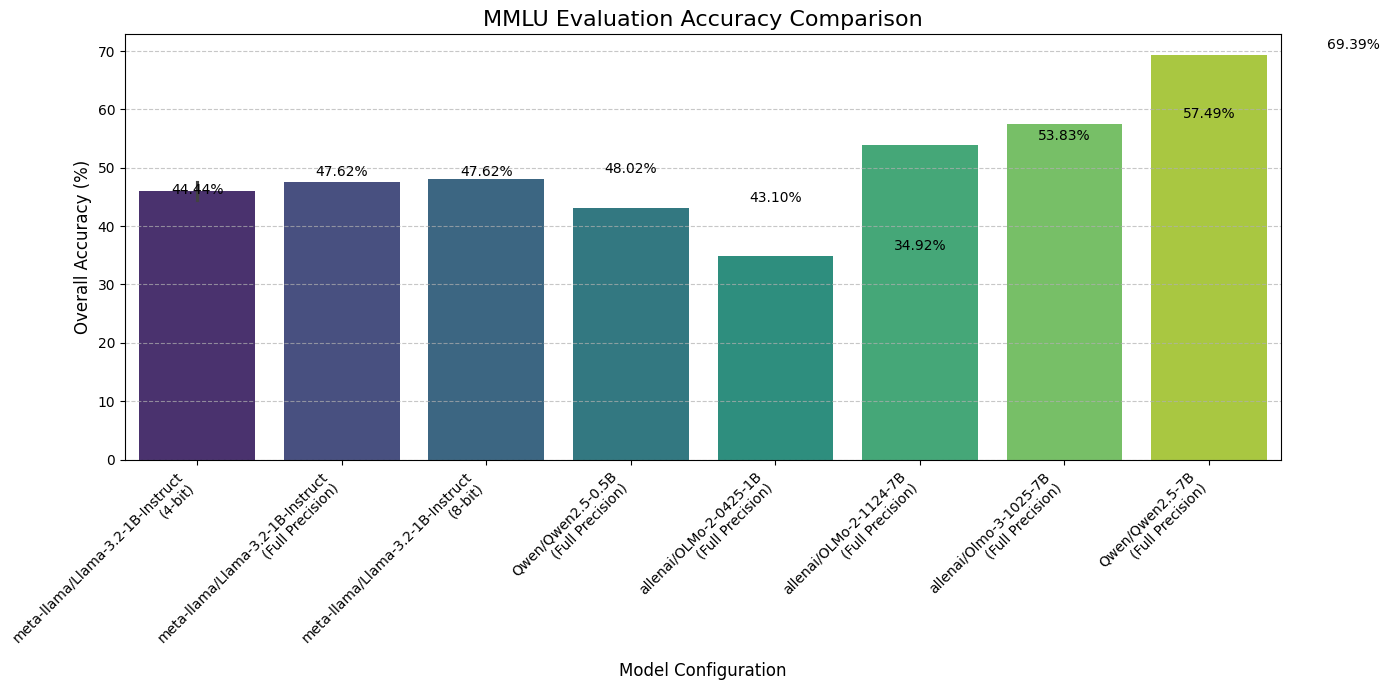

In [5]:
import re
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

log_path = '/content/timelog.txt'

with open(log_path, 'r') as f:
    content = f.read()

# Split content into blocks roughly by "EVALUATION SUMMARY"
# We use the "EVALUATION SUMMARY" header as a delimiter
blocks = content.split('EVALUATION SUMMARY')

data = []

for block in blocks:
    if "Model:" not in block or "Overall Accuracy:" not in block:
        continue

    # Extract Model
    model_match = re.search(r'Model:\s+(.+)', block)
    model = model_match.group(1).strip() if model_match else "Unknown"

    # Extract Quantization
    # It can be explicitly labeled or implied by "None (full precision)" appearing
    quant = "Unknown"
    if "Quantization:" in block:
        quant_match = re.search(r'Quantization:\s+(.+)', block)
        if quant_match:
            quant = quant_match.group(1).strip()

    if quant == "Unknown":
        if "None (full precision)" in block:
            quant = "None (full precision)"
        elif "4-bit" in block:
            quant = "4-bit"
        elif "8-bit" in block:
            quant = "8-bit"

    # Clean up quantization label for plot
    if "None" in quant or "full" in quant.lower():
        quant = "Full Precision"
    elif "4-bit" in quant:
        quant = "4-bit"
    elif "8-bit" in quant:
        quant = "8-bit"

    # Extract Accuracy
    acc_match = re.search(r'Overall Accuracy:\s+([0-9.]+)', block)
    if acc_match:
        accuracy = float(acc_match.group(1))
    else:
        continue

    # Label for the plot
    label = f"{model}\n({quant})"

    data.append({
        "Model": model,
        "Quantization": quant,
        "Accuracy": accuracy,
        "Label": label
    })

# Create DataFrame
df = pd.DataFrame(data)

# Drop duplicates if any (in case log was appended multiple times)
df = df.drop_duplicates()

# Display Data
print("Extracted Data:")
display(df)

# Plotting
if not df.empty:
    plt.figure(figsize=(14, 7))
    sns.barplot(data=df, x='Label', y='Accuracy', palette='viridis', hue='Label', legend=False)

    plt.title('MMLU Evaluation Accuracy Comparison', fontsize=16)
    plt.ylabel('Overall Accuracy (%)', fontsize=12)
    plt.xlabel('Model Configuration', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Add value labels on top of bars
    for i, v in enumerate(df['Accuracy']):
        plt.text(i, v + 1, f"{v:.2f}%", ha='center', fontsize=10)

    plt.tight_layout()
    plt.show()
else:
    print("No data found to visualize.")